In [182]:
import pandas as pd
from linearmodels import PanelOLS
import numpy as np

def prepare_data():
    """Prepare data for regression analysis"""
    filepath = r'at.dta'
    df = pd.read_stata(filepath)
    df = df.set_index(['app_num', 'ym'])
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    return df

def generate_summary_statistics(data):
    """Generate summary statistics for main variables"""
    variables = ['Rating', 'Log_Demand', 'Age', 'Price',
                 'Log_Firm_Size', 'One_Employee']
    
    summary_stats = data[variables].agg(['mean', 'std', 'min', 'median', 'max']).T
    summary_stats.columns = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']
    
    return summary_stats

def run_panel_ols(data, model_type='full'):
    """Run panel OLS regression"""
    Y = data['Rating']
    
    if model_type == 'simple':
        X = data[['TREATXAFTER_BAN', 'genre_cons']]
    else:  # full model
        X = data[['TREATXAFTER_BAN', 'genre_cons', 'Log_Demand', 
                  'Price', 'Log_Firm_Size', 'One_Employee', 'Age']]
    
    model = PanelOLS(Y, X, entity_effects=True, time_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)
    
    return results

def main():
    df = prepare_data()

    # Run summary statistics
    summary_stats = generate_summary_statistics(df)
    print("Summary Statistics:")
    print(summary_stats)
    
    # Run simple model
    simple_results = run_panel_ols(df, model_type='simple')
    print("\nSimple Model Results:")
    print(simple_results)
    
    # Run full model
    full_results = run_panel_ols(df, model_type='full')
    print("\nFull Model Results:")
    print(full_results)
    
    return summary_stats, simple_results, full_results, df

if __name__ == "__main__":
    summary_stats, simple_results, full_results, df = main()

Summary Statistics:
                     Mean     Std Dev       Min      Median          Max
Rating           4.061931    0.522589  1.000000    4.100000     5.000000
Log_Demand       6.308229    3.208901  0.000000    6.426488    15.716231
Age            696.624329  613.680298  1.000000  489.000000  3639.000000
Price            0.004623    0.067865  0.000000    0.000000     1.000000
Log_Firm_Size    2.554413    1.227991  0.693147    2.484907     7.239215
One_Employee     0.859508    0.347312  0.000000    1.000000     1.000000

Simple Model Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                 Rating   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):             -0.0056
No. Observations:               93428   R-squared (Within):              -0.0182
Date:                Sat, Oct 19 2024   R-squared (Overall):             -0.0061
Time:                        22:28:30   L

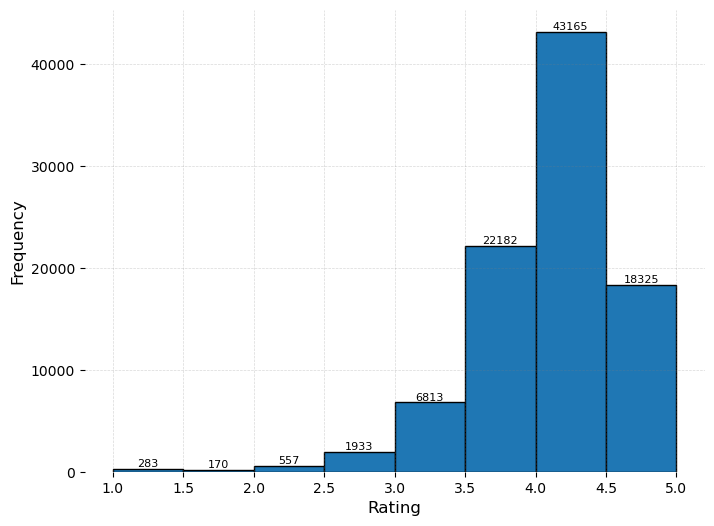

In [264]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(1, 5.5, 0.5)
plt.figure(figsize=(8, 6))

# Plot the histogram and save the patches for the bars
n, bins, patches = plt.hist(df['Rating'], bins=bins, color='#1f77b4', edgecolor='black', linewidth=1)

# Add value labels above each bar, centered over each bar
for patch in patches:
    # Get the bar's center
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2  # Center of the bar
    plt.text(x, height, str(int(height)), ha='center', va='bottom', fontsize=8)

plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(bins, fontsize=10)
plt.yticks(fontsize=10)

# Custom grid function to avoid lines passing through the bars
def custom_grid(ax, which='major'):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    for x in xticks:
        if x >= xmin and x <= xmax:
            ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    for y in yticks:
        if y >= ymin and y <= ymax:
            ax.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

plt.grid(False)  # Turn off the default grid
custom_grid(plt.gca())
plt.box(on=None)

plt.savefig('distribution_of_game_ratings.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [244]:
import pandas as pd

df = prepare_data()

# Group by app_num and count the instances
app_counts = df.groupby('app_num').size()

# Calculate the average count
average_count = app_counts.mean()

print("Average count of app_num instances:", average_count)

Average count of app_num instances: 17.091875214261226


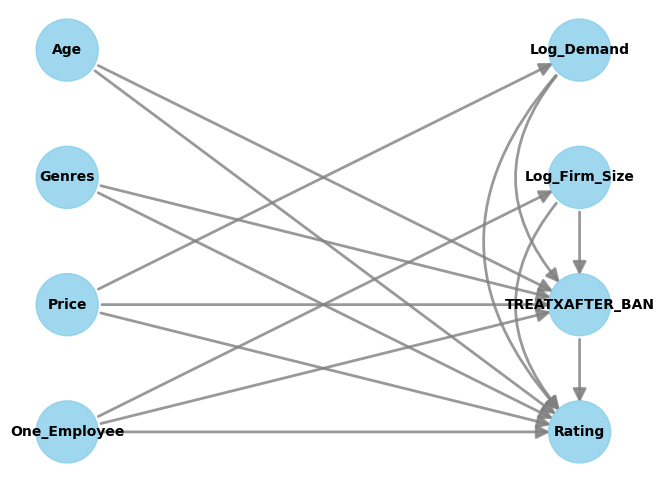

In [180]:
import warnings
from dowhy import CausalModel

# Suppress warnings for better clarity
warnings.filterwarnings("ignore")

# Define treatment and outcome variables
treatment = 'TREATXAFTER_BAN'
outcome = 'Rating'

# Prepare data
df = prepare_data()

# Define the causal model with a clear graph structure
model = CausalModel(
    data=df, 
    treatment=treatment, 
    outcome=outcome, 
    graph="""graph[directed 1
        node[id "Log_Demand" label "Log_Demand"]
        node[id "Age" label "Age"]
        node[id "genre_cons" label "Genres"]
        node[id "Price" label "Price"]
        node[id "One_Employee" label "One_Employee"]
        node[id "Log_Firm_Size" label "Log_Firm_Size"]
        node[id "TREATXAFTER_BAN" label "TREATXAFTER_BAN"]
        node[id "Rating" label "Rating"]
        
        edge[source "Log_Demand" target "TREATXAFTER_BAN"]
        edge[source "Age" target "TREATXAFTER_BAN"]
        edge[source "genre_cons" target "TREATXAFTER_BAN"]
        edge[source "Price" target "TREATXAFTER_BAN"]
        edge[source "One_Employee" target "TREATXAFTER_BAN"]
        edge[source "Log_Firm_Size" target "TREATXAFTER_BAN"]
        
        edge[source "Price" target "Log_Demand"]
        edge[source "One_Employee" target "Log_Firm_Size"]
        
        edge[source "Log_Demand" target "Rating"]
        edge[source "Age" target "Rating"]
        edge[source "genre_cons" target "Rating"]
        edge[source "Price" target "Rating"]
        edge[source "One_Employee" target "Rating"]
        edge[source "Log_Firm_Size" target "Rating"]
        edge[source "TREATXAFTER_BAN" target "Rating"]
    ]
    """
)

# Visualize the causal model
model.view_model()


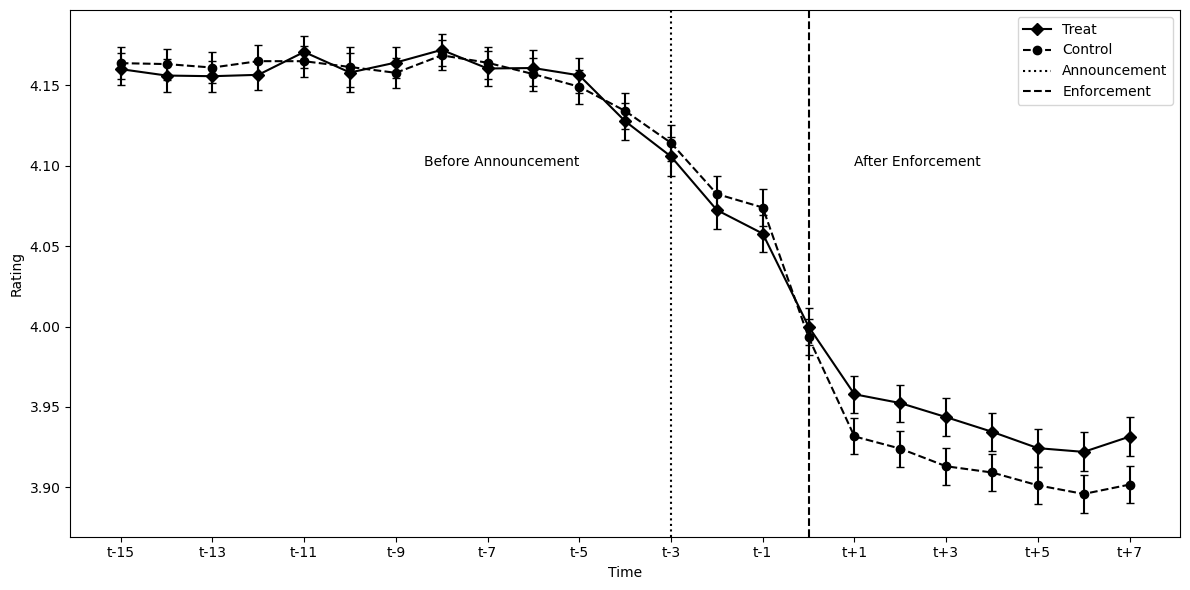

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = prepare_data()

# Calculate the mean Rating and standard error for each group over time
def calc_stats(group):
    return pd.Series({
        'mean': group['Rating'].mean(),
        'se': group['Rating'].sem()
    })

treat_stats = df[df['ann_TREAT'] == 1].groupby('ym').apply(calc_stats).reset_index()
control_stats = df[df['ann_TREAT'] == 0].groupby('ym').apply(calc_stats).reset_index()

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(treat_stats['ym'], treat_stats['mean'], color='black', linestyle='solid', marker='D', label='Treat')
ax.plot(control_stats['ym'], control_stats['mean'], color='black', linestyle='dashed', marker='o', label='Control')

# Add error bars
ax.errorbar(treat_stats['ym'], treat_stats['mean'], yerr=treat_stats['se'], 
            fmt='none', ecolor='black', capsize=3)
ax.errorbar(control_stats['ym'], control_stats['mean'], yerr=control_stats['se'], 
            fmt='none', ecolor='black', capsize=3)

ax.set_xlabel('Time')
ax.set_ylabel('Rating')

# Adjust x-ticks to span the entire graph with 't' as the benchmark
min_ym = int(min(treat_stats['ym'].min(), control_stats['ym'].min()))
max_ym = int(max(treat_stats['ym'].max(), control_stats['ym'].max()))
benchmark_ym = 715  # This was previously 't+3', now it's 't'

ym_range = list(range(min_ym, max_ym + 1, 2))  # Adjust step size if needed
labels = [f't{i - benchmark_ym:+d}' if i != benchmark_ym else 't' for i in ym_range]

ax.set_xticks(ym_range)
ax.set_xticklabels(labels)

ax.grid(False)
ax.axvline(712, color='black', linestyle='dotted', label='Announcement')
ax.axvline(715, color='black', linestyle='--', label='Enforcement')
ax.text(710, 4.1, 'Before Announcement', ha='right')
ax.text(716, 4.1, 'After Enforcement', ha='left')
ax.legend()

plt.tight_layout()
plt.savefig('fig_rating_with_se_adjusted.pdf')